In [6]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *                       
from etl import *

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### etl (new readfilerun and gen)

In [40]:
%%timeit
df = readfilerun_simple('data/raw/train_r/20220116T055105_20-100-true-20-100-iperf.csv')
df10 = agg10(genfeat(df))
# df

33.5 s ± 5.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
genfeat(df)

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1642312265,172.21.0.3,40878,172.19.0.2,5001,6,553500,18292,369,316,...,571792,8,1.008772,29,137,19628,571792,834.732847,690,834.732847
1,1642312266,172.21.0.3,40878,172.19.0.2,5001,6,235500,8432,157,155,...,243932,4,3.135048,27,79,9260,243932,781.833333,975,781.833333
2,1642312267,172.21.0.3,40878,172.19.0.2,5001,6,289500,9988,193,186,...,299488,3,2.574074,22,62,9364,299488,790.205805,973,790.205805
3,1642312268,172.21.0.3,40878,172.19.0.2,5001,6,405000,9228,270,173,...,414228,8,2.235294,22,63,13708,414228,935.051919,988,935.051919
5,1642312269,172.21.0.3,40878,172.19.0.2,5001,6,232500,3364,155,61,...,235864,8,4.562791,90,46,12052,235864,1091.962963,981,1091.962963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1642312560,172.21.0.3,40878,172.19.0.2,5001,6,309000,4152,206,78,...,313152,6,3.286219,43,26,16796,313152,1102.647887,930,1102.647887
302,1642312561,172.21.0.3,40878,172.19.0.2,5001,6,237000,3576,158,66,...,240576,6,4.372197,43,35,13708,240576,1074.000000,975,1074.000000
303,1642312562,172.21.0.3,40878,172.19.0.2,5001,6,366000,4896,244,93,...,370896,6,2.901786,43,27,21312,370896,1100.581602,975,1100.581602
304,1642312563,172.21.0.3,40878,172.19.0.2,5001,6,316500,4548,211,84,...,321048,6,3.176871,43,28,21260,321048,1088.298305,934,1088.298305


In [34]:
df['group'] = df.index // 20
print(df.shape)
# df.groupby('group').agg(pd.Series.mode)
agg20 = better_agg(genfeat(df), 20)
agg20

(300, 28)


TypeError: 'float' object is not iterable

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

df = pd.read_csv('outputs\\combined_transform.csv')
df


,total_bytes,max_bytes,proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,number_ms,pkt_ratio,time_spread,pkt sum,longest_seq,total_pkt_sizes,byte_ratio,loss,latency
0,147546.4,3977.820375,6.0,143716.4,3830.0,96.0,70.9,166.9,36.3,928.661778,905.6,147546.4,5.0,147546.4,1066.509474,100.0,100.0
1,82518.8,2954.589921,6.0,81300.0,1218.8,54.2,22.5,76.7,17.6,1073.823761,901.3,82518.8,5.1,82518.8,1066.509474,100.0,100.0
2,72773.6,2132.137165,6.0,71550.0,1223.6,47.7,22.3,70.0,20.0,1037.201125,920.1,72773.6,4.6,72773.6,1066.509474,100.0,100.0
3,77979.2,2056.799196,6.0,76800.0,1179.2,51.2,22.1,73.3,20.4,1063.096983,916.3,77979.2,4.5,77979.2,1066.509474,100.0,100.0
4,148404.0,2450.035501,6.0,146400.0,2004.0,97.6,37.2,134.8,27.5,1099.955806,960.5,148404.0,6.4,148404.0,1066.509474,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,1181395.2,4610.190760,6.0,1167000.0,14395.2,778.0,270.9,1048.9,125.5,1128.508362,911.9,1181395.2,7.6,1181395.2,1105.379896,9000.0,500.0
7703,1352562.4,5613.342138,6.0,1335600.0,16962.4,890.4,326.2,1216.6,140.1,1110.808290,953.7,1352562.4,7.5,1352562.4,1105.379896,9000.0,500.0
7704,2152011.2,113913.653088,6.0,2121928.8,30082.4,1414.8,536.3,1951.1,211.4,1098.366122,664.8,2152011.2,220.4,2152011.2,1105.379896,9000.0,500.0
7705,1420124.8,134999.098851,6.0,1401492.0,18632.8,934.6,324.6,1259.2,151.1,1125.585269,668.7,1420124.8,174.8,1420124.8,1105.379896,9000.0,500.0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

df = pd.read_csv('outputs\\combined_transform.csv')
df


,total_bytes,max_bytes,proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,number_ms,pkt_ratio,time_spread,pkt sum,longest_seq,total_pkt_sizes,byte_ratio,loss,latency
0,147546.4,3977.820375,6.0,143716.4,3830.0,96.0,70.9,166.9,36.3,928.661778,905.6,147546.4,5.0,147546.4,1066.509474,100.0,100.0
1,82518.8,2954.589921,6.0,81300.0,1218.8,54.2,22.5,76.7,17.6,1073.823761,901.3,82518.8,5.1,82518.8,1066.509474,100.0,100.0
2,72773.6,2132.137165,6.0,71550.0,1223.6,47.7,22.3,70.0,20.0,1037.201125,920.1,72773.6,4.6,72773.6,1066.509474,100.0,100.0
3,77979.2,2056.799196,6.0,76800.0,1179.2,51.2,22.1,73.3,20.4,1063.096983,916.3,77979.2,4.5,77979.2,1066.509474,100.0,100.0
4,148404.0,2450.035501,6.0,146400.0,2004.0,97.6,37.2,134.8,27.5,1099.955806,960.5,148404.0,6.4,148404.0,1066.509474,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,1181395.2,4610.190760,6.0,1167000.0,14395.2,778.0,270.9,1048.9,125.5,1128.508362,911.9,1181395.2,7.6,1181395.2,1105.379896,9000.0,500.0
7703,1352562.4,5613.342138,6.0,1335600.0,16962.4,890.4,326.2,1216.6,140.1,1110.808290,953.7,1352562.4,7.5,1352562.4,1105.379896,9000.0,500.0
7704,2152011.2,113913.653088,6.0,2121928.8,30082.4,1414.8,536.3,1951.1,211.4,1098.366122,664.8,2152011.2,220.4,2152011.2,1105.379896,9000.0,500.0
7705,1420124.8,134999.098851,6.0,1401492.0,18632.8,934.6,324.6,1259.2,151.1,1125.585269,668.7,1420124.8,174.8,1420124.8,1105.379896,9000.0,500.0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

df = pd.read_csv('outputs\\combined_transform.csv')
df


,total_bytes,max_bytes,proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,number_ms,pkt_ratio,time_spread,pkt sum,longest_seq,total_pkt_sizes,byte_ratio,loss,latency
0,147546.4,3977.820375,6.0,143716.4,3830.0,96.0,70.9,166.9,36.3,928.661778,905.6,147546.4,5.0,147546.4,1066.509474,100.0,100.0
1,82518.8,2954.589921,6.0,81300.0,1218.8,54.2,22.5,76.7,17.6,1073.823761,901.3,82518.8,5.1,82518.8,1066.509474,100.0,100.0
2,72773.6,2132.137165,6.0,71550.0,1223.6,47.7,22.3,70.0,20.0,1037.201125,920.1,72773.6,4.6,72773.6,1066.509474,100.0,100.0
3,77979.2,2056.799196,6.0,76800.0,1179.2,51.2,22.1,73.3,20.4,1063.096983,916.3,77979.2,4.5,77979.2,1066.509474,100.0,100.0
4,148404.0,2450.035501,6.0,146400.0,2004.0,97.6,37.2,134.8,27.5,1099.955806,960.5,148404.0,6.4,148404.0,1066.509474,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,1181395.2,4610.190760,6.0,1167000.0,14395.2,778.0,270.9,1048.9,125.5,1128.508362,911.9,1181395.2,7.6,1181395.2,1105.379896,9000.0,500.0
7703,1352562.4,5613.342138,6.0,1335600.0,16962.4,890.4,326.2,1216.6,140.1,1110.808290,953.7,1352562.4,7.5,1352562.4,1105.379896,9000.0,500.0
7704,2152011.2,113913.653088,6.0,2121928.8,30082.4,1414.8,536.3,1951.1,211.4,1098.366122,664.8,2152011.2,220.4,2152011.2,1105.379896,9000.0,500.0
7705,1420124.8,134999.098851,6.0,1401492.0,18632.8,934.6,324.6,1259.2,151.1,1125.585269,668.7,1420124.8,174.8,1420124.8,1105.379896,9000.0,500.0


In [ ]:
indexcol = ['total_bytes','max_bytes','2->1Bytes','2->1Pkts','total_pkts', 'total_pkts_min', 'total_pkts_max', 'number_ms', 'pkt_ratio','time_spread', 'time_spread_min','time_spread_max','pkt sum','longest_seq', 'longest_seq_min', 'longest_seq_max','total_pkt_sizes','byte_ratio', 'mean_tdelta', 'max_tdelta']
len(indexcol)

20

['total_bytes',
 'max_bytes',
 '2->1Bytes',
 '2->1Pkts',
 'total_pkts',
 'number_ms',
 'pkt_ratio',
 'time_spread',
 'pkt sum',
 'longest_seq',
 'total_pkt_sizes',
 'byte_ratio']

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

label_col = 'loss'

df = pd.read_csv('outputs\\combined_transform.csv')

# indexcol = ['total_bytes','max_bytes','2->1Bytes','2->1Pkts','total_pkts', 'total_pkts_min', 'total_pkts_max', 'number_ms', 'pkt_ratio','time_spread', 'time_spread_min','time_spread_max','pkt sum','longest_seq', 'longest_seq_min', 'longest_seq_max','total_pkt_sizes','byte_ratio', 'mean_tdelta', 'max_tdelta']
indexcol = ['total_bytes', 'max_bytes', '2->1Bytes', '2->1Pkts', 'total_pkts',
       'number_ms', 'pkt_ratio', 'time_spread', 'pkt sum', 'longest_seq',
       'total_pkt_sizes', 'byte_ratio', 'mean_tdelta', 'max_tdelta']
print(len(indexcol),df[[x for x in indexcol if x in df.columns]])

X_train, X_test, y_train, y_test = train_test_split(
    df[[x for x in indexcol if x in df.columns]], df[label_col])
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
etree = ExtraTreesRegressor(n_estimators=400, n_jobs=4)
etreeft = etree.fit(X_train,y_train)

y_pred3 = etree.predict(X_test)
acc3= mean_squared_error(y_test, y_pred3)

print(f'mse: {acc3}, r2: {etree.score(X_test, y_test)}')
feat_imp = pd.Series(index=[x for x in indexcol if x in df.columns], 
          data=etree.feature_importances_).sort_values(ascending=False)
feat_imp

14       total_bytes      max_bytes  2->1Bytes  2->1Pkts  total_pkts  number_ms  \
0        147546.4    3977.820375     3830.0      70.9       166.9       36.3   
1         82518.8    2954.589921     1218.8      22.5        76.7       17.6   
2         72773.6    2132.137165     1223.6      22.3        70.0       20.0   
3         77979.2    2056.799196     1179.2      22.1        73.3       20.4   
4        148404.0    2450.035501     2004.0      37.2       134.8       27.5   
...           ...            ...        ...       ...         ...        ...   
7702    1181395.2    4610.190760    14395.2     270.9      1048.9      125.5   
7703    1352562.4    5613.342138    16962.4     326.2      1216.6      140.1   
7704    2152011.2  113913.653088    30082.4     536.3      1951.1      211.4   
7705    1420124.8  134999.098851    18632.8     324.6      1259.2      151.1   
7706    1346331.2    2489.590096    18231.2     350.6      1236.0      148.0   

        pkt_ratio  time_spread    pk

2->1Bytes          0.126473
byte_ratio         0.125211
2->1Pkts           0.113406
total_pkts         0.097654
total_bytes        0.096245
max_tdelta         0.085627
total_pkt_sizes    0.084229
number_ms          0.074326
pkt sum            0.065050
mean_tdelta        0.038659
time_spread        0.031764
pkt_ratio          0.022625
longest_seq        0.019405
max_bytes          0.019326
dtype: float64

In [89]:
df = readfilerun_simple('data/raw/switch/20220119T055428_300-500-true-300-5000-iperf.csv', 'data/raw/switch')
df.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs,event,drop_unix,latency,loss,later_latency,later_loss,deterministic
0,1642571669,172.21.0.3,40760,172.19.0.2,5001,6,13664,60,11,1,1642571669465;1642571669465;1642571669465;1642...,60;52;112;1500;1500;1500;1500;1500;1500;1500;1...,2;1;1;1;1;1;1;1;1;1;1;1;,NaN,NaN,300,500,300,5000,True
4,1642571670,172.21.0.3,40760,172.19.0.2,5001,6,84000,1040,56,20,1642571670068;1642571670068;1642571670068;1642...,52;1500;1500;52;1500;1500;52;1500;1500;52;1500...,2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;...,drop,1642571670.678649,300,500,300,5000,True
5,1642571671,172.21.0.3,40760,172.19.0.2,5001,6,189000,3152,126,56,1642571671276;1642571671276;1642571671276;1642...,52;1500;1500;1500;1500;52;1500;1500;52;1500;15...,2;1;1;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;...,drop,1642571671.890071,300,500,300,5000,True
6,1642571672,172.21.0.3,40760,172.19.0.2,5001,6,81000,2768,54,50,1642571672483;1642571672483;1642571672484;1642...,52;1500;52;1500;1500;52;52;1500;1500;52;1500;1...,2;1;2;1;1;2;2;1;1;2;1;1;2;2;1;1;2;2;1;1;2;1;1;...,NaN,NaN,300,500,300,5000,True
7,1642571673,172.21.0.3,40760,172.19.0.2,5001,6,132000,4264,88,76,1642571673087;1642571673087;1642571673087;1642...,64;64;1500;64;1500;64;1500;64;64;1500;64;1500;...,2;2;1;2;1;2;1;2;2;1;2;1;2;2;1;2;1;2;2;1;2;1;2;...,NaN,NaN,300,500,300,5000,True


In [90]:
tdf = agg10(genfeat(df))
tdf.head()

,total_bytes,max_bytes,proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,total_pkts_min,total_pkts_max,...,pkt sum,longest_seq,longest_seq_min,longest_seq_max,total_pkt_sizes,byte_ratio,mean_tdelta,max_tdelta,loss,latency
0,107325.6,7132.184842,6.0,104266.4,3059.2,69.7,56.3,126.0,12.0,192.0,...,107325.6,4.6,2.0,11.0,107325.6,1069.182256,2.647068,358.2,500.0,300.0
1,149212.8,3786.317918,6.0,146850.0,2362.8,97.9,44.6,142.5,74.0,184.0,...,149212.8,5.5,4.0,8.0,149212.8,1069.182256,5.601969,408.7,500.0,300.0
2,132266.4,5905.853729,6.0,130350.0,1916.4,86.9,36.0,122.9,64.0,185.0,...,132266.4,5.9,4.0,8.0,132266.4,1069.182256,8.013509,217.9,500.0,300.0
3,562985.2,10036.535604,6.0,554400.0,8585.2,369.6,157.1,526.7,320.0,923.0,...,562985.2,7.2,4.0,10.0,562985.2,1069.182256,1.942601,134.0,500.0,300.0
4,361448.4,3214.724706,6.0,355800.0,5648.4,237.2,105.3,342.5,222.0,441.0,...,361448.4,6.3,4.0,11.0,361448.4,1069.182256,2.972111,88.7,500.0,300.0


In [91]:
tdf_x = tdf[indexcol]
tdf_x
tdf['loss_pred'] = etree.predict(tdf_x)
tdf['loss_pred']

0       244.875
1       258.500
2       207.500
3      3697.125
4      1936.625
5       339.375
6       232.375
7       380.625
8       240.000
9       247.500
10      249.625
11      227.250
12      251.625
13      402.000
14      706.125
15      607.500
16      430.000
17      569.125
18     1425.250
19    12620.000
20    12697.500
21     8270.000
22     6136.250
23     3295.625
24     1517.875
25     4582.500
26    14280.000
27    12610.000
28     6436.875
29     7003.750
Name: loss_pred, dtype: float64

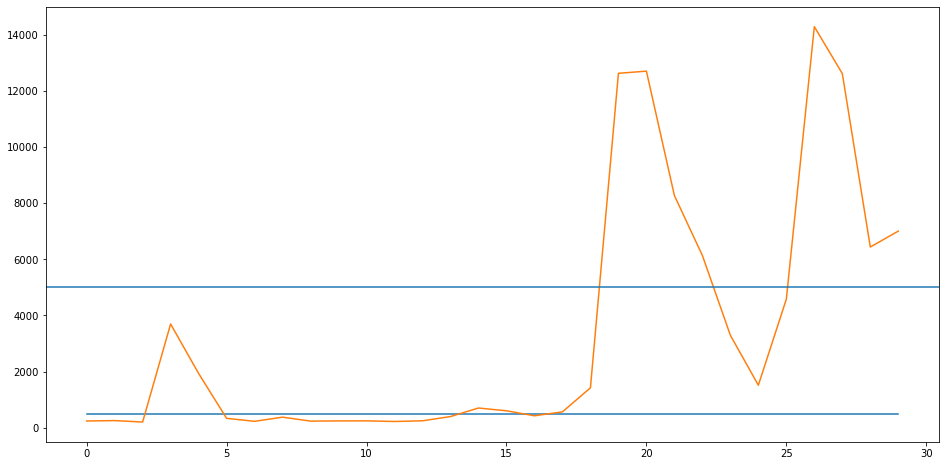

In [98]:
plt.figure(figsize=(16, 8))
tdf['loss'].plot()
tdf['loss_pred'].plot()
plt.axhline(5000)

In [80]:
tdf.iloc[0]

total_bytes        107325.600000
max_bytes            7132.184842
2->1Bytes            3059.200000
2->1Pkts               56.300000
total_pkts            126.000000
number_ms              14.600000
pkt_ratio             884.515287
time_spread           374.800000
pkt sum            107325.600000
longest_seq             4.600000
total_pkt_sizes    107325.600000
byte_ratio           1069.182256
mean_tdelta             2.647068
max_tdelta            358.200000
Name: 0, dtype: float64

In [ ]:
print(f'mse: {acc3}, r2: {etree.score(X_test, y_test)}')
feat_imp = pd.Series(index=[x for x in indexcol if x in df.columns], 
          data=etree.feature_importances_).sort_values(ascending=False)
feat_imp

mse: 1888.4178210949665, r2: 0.9239026238224772


byte_ratio         0.570085
time_spread        0.099886
pkt_ratio          0.069825
number_ms          0.069792
max_bytes          0.028858
pkt sum            0.024635
total_pkts         0.023934
total_pkt_sizes    0.023690
2->1Bytes          0.022993
2->1Pkts           0.022918
total_bytes        0.022051
longest_seq        0.021332
dtype: float64

In [ ]:
pd.Series(index=[x for x in indexcol if x in df.columns], 
          data=etree.feature_importances_).sort_values(ascending=False)


byte_ratio         0.570085
time_spread        0.099886
pkt_ratio          0.069825
number_ms          0.069792
max_bytes          0.028858
pkt sum            0.024635
total_pkts         0.023934
total_pkt_sizes    0.023690
2->1Bytes          0.022993
2->1Pkts           0.022918
total_bytes        0.022051
longest_seq        0.021332
dtype: float64